# [Moduel 3.1] AutoGluon-Tabular in AWS Marketplace

본 노트북은 아래 노트북의 내용을 데이타를 제외하고 대부분 가져왔습니다.
- https://github.com/mullue/autogluon-mkp
- https://github.com/aws/amazon-sagemaker-examples/tree/master/aws_marketplace/using_algorithms/autogluon

[AutoGluon](https://github.com/awslabs/autogluon) 은 머신리닝을 자동화하여 여러분의 응용프로그램에 쉽게 강력한 예측성능을 제공할 수 있도록 합니다. 몇줄의 코드만으로 여러분은 테이블, 이미지, 텍스트데이터에 대하여 고성능의 딥러닝 모델을 학습하고 배포할 수 있습니다. 본 노트북은 테이블형식의 데이터에 대하여 AWS마켓플레이스에 있는 AutoGluon-Tabluar 를 어떻게 적용하는지 보여드립니다.

### 이 노트북은 소요 시간이 약 30 분 걸립니다.


### Contents:
* [Step 1: Subscribe to AutoML algorithm from AWS Marketplace](#Step-1:-Subscribe-to-AutoML-algorithm-from-AWS-Marketplace)
* [Step 2: Set up environment](#Step-2-:-Set-up-environment)
* [Step 3: Prepare and upload data](#Step-3:-Prepare-and-upload-data)
* [Step 4: Train a model](#Step-4:-Train-a-model)
* [Step 5: Deploy the model and perform a real-time inference](#Step-5:-Deploy-the-model-and-perform-a-real-time-inference)
* [Step 6: Use Batch Transform](#Step-6:-Use-Batch-Transform)
* [Step 7: Clean-up](#Step-7:-Clean-up)

### Step 1: Subscribe to AutoML algorithm from AWS Marketplace

1. 마켓플레이스에 접속하고 [AutoGluon-Tabular](https://aws.amazon.com/marketplace/pp/prodview-n4zf5pmjt7ism) 페이지를 오픈합니다.
2. **Highlights** 부분과 **product overview** 부분을 읽어봅니다. (알고리즘의 개요와 동작특성, 특장점 등을 설명하고 있습니다.)
3. **usage information** 부분과 **additional resources** 부분을 살펴봅니다. (알고리즘의 사용방법이 설명됩니다.)
4. 지원되는 인스턴스 타입을 살펴봅니다. 본 노트북의 이후 셀에서 해당 타입을 설정할 것입니다. 
5. **Continue to subscribe** 버튼을 클릭합니다.
6. **End user license agreement**, **support terms**, **pricing information**을 읽어봅니다.
7. 여러분의 조직에서 해당 알고리즘의 라이센스, 가격, 지원정책에 동의하는 경우 **Accept offer** 버튼을 클릭합니다. 

**Notes**: 
1. **Continue to configuration** 버튼이 활성회되면 여러분의 어카운트가 subscription 된 상태입니다. 
2. **Continue to configuration** 버튼을 클릭하고 리전을 선택하면 `Product Arn`을 확인할 수 있습니다. 이 값이 여러분의 학습작업에서 사용할 알고리즘 ARN입니다. (단, 본 노트북에서는 이미 리전별 ARN 값들을 **src/algorithm_arns.py** 파일에 저장해 두었기 때문에 특별히 설정할 필요는 없습니다.) 


### Step 2 : Set up environment

In [22]:
# Import the latest sagemaker and boto3 SDKs
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=2.0.0" tqdm
!{sys.executable} -m pip show sagemaker

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.2.4)
Name: sagemaker
Version: 2.16.3
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages
Requires: numpy, smdebug-rulesconfig, protobuf3-to-dict, packaging, importlib-metadata, boto3, protobuf, google-pasta
Required-by: 


In [23]:
#Import necessary libraries.
import os
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from sagemaker import get_execution_role, local, Model, utils, fw_utils, s3
from sagemaker import AlgorithmEstimator
from sagemaker.predictor import RealTimePredictor, csv_serializer, StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# Print settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

# Account/s3 setup
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'sagemaker/autogluon-tabular'
region = session.boto_region_name
role = get_execution_role()


In [24]:
compatible_training_instance_type='ml.m5.4xlarge' 
compatible_inference_instance_type='ml.m5.4xlarge' 

In [25]:
#Specify algorithm ARN for AutoGluon-Tabular from AWS Marketplace.  However, for this notebook, the algorithm ARN 
#has been specified in src/algorithm_arns.py file and you do not need to specify the same explicitly.

from src.algorithm_arns import AlgorithmArnProvider

algorithm_arn = AlgorithmArnProvider.get_algorithm_arn(region)

### Step 3: Get the data

기존에 만든 데이터를 로딩하고 합니다. AutoGluon 이용시 별도의 검증(validation)셋의 생성은 필요하지 않습니다. (내부적으로 k-fold cross-validation을 이용합니다.)


In [27]:
%store -r no_auto_train_file
%store -r no_auto_test_file

train = pd.read_csv(no_auto_train_file)
test = pd.read_csv(no_auto_test_file)

# Split test X/y
label = 'classes'
y_test = test[label]
X_test = test.drop(columns=[label])
print("auto_train_file: ", train.shape)
print("auto_train_file: ", test.shape)


auto_train_file:  (53740, 18)
auto_train_file:  (13436, 18)


- train, test 데이터는 레이블 컬럼 `classes`를 포함하고 있습니다.
- X_test 데이터는 레이블 컬럼 `classes`를 포함하고 있지 않습니다.



In [28]:
from IPython.display import display as dp
dp(train.head(2))
dp(test.head(2))
dp(X_test.head(2))




,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,12030,taubate,SP,29.99,10.96,9000.0,fashion_shoes,13481,limeira,SP,1,4,10,SP_SP,taubate_limeira,12030_13481,2640.0
1,2,78075,cuiaba,MT,23.90,26.82,1500.0,furniture_decor,17051,bauru,SP,1,4,10,MT_SP,cuiaba_bauru,78075_17051,14625.0


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,0,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


데이터를 S3로 업로드합니다. 

In [29]:
from p_utils import upload_s3

# Upload train. test file
data_prefix = 'autogluon/predict-deliver-time/data'

train_s3_path = upload_s3(bucket, no_auto_train_file, data_prefix)
test_s3_path = upload_s3(bucket, no_auto_test_file, data_prefix)
print("train_s3_path: ", train_s3_path)
print("test_s3_path: ", test_s3_path)

train_s3_path:  s3://sagemaker-ap-northeast-2-057716757052/autogluon/predict-deliver-time/data/preproc_data/auto_no_fe/train/train.csv
test_s3_path:  s3://sagemaker-ap-northeast-2-057716757052/autogluon/predict-deliver-time/data/preproc_data/auto_no_fe/test/test.csv


### Step 4: Train a model

이제 모델을 학습하겠습니다. 

**주의:** 적절한 디스크 사이즈 할당을 위해 `train_volume_size`값을 조정해야 할 수 있습니다.


In [30]:
# Define required label and optional additional parameters
fit_args = {
  'label': 'classes',
  # Adding 'best_quality' to presets list will result in better performance (but longer runtime)
  'presets': ['optimize_for_deployment'],
}

# Pass fit_args to SageMaker estimator hyperparameters
hyperparameters = {
  'fit_args': fit_args,
  'feature_importance': True
}

In [31]:
algo = AlgorithmEstimator(algorithm_arn=algorithm_arn, 
                          role=role, 
                          instance_count=1, 
                          instance_type=compatible_training_instance_type, 
                          sagemaker_session=session, 
                          base_job_name='autogluon',
                          hyperparameters=hyperparameters,
                          train_volume_size=100) 

inputs = {'training': train_s3_path, 'testing': test_s3_path}

algo.fit(inputs)

2020-11-17 09:23:55 Starting - Starting the training job...
2020-11-17 09:23:57 Starting - Launching requested ML instances......
2020-11-17 09:25:21 Starting - Preparing the instances for training...
2020-11-17 09:25:50 Downloading - Downloading input data...
2020-11-17 09:25:55 Training - Downloading the training image.....2020-11-17 09:27:07,322 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2020-11-17 09:27:07,324 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-17 09:27:07,325 sagemaker-training-toolkit INFO     Failed to parse hyperparameter fit_args value {'label': 'classes', 'presets': ['optimize_for_deployment']} to Json.
Returning the value itself
2020-11-17 09:27:07,325 sagemaker-training-toolkit INFO     Failed to parse hyperparameter feature_importance value True to Json.
Returning the value itself
2020-11-17 09:27:07,335 sagemaker_mxnet_container.training INFO     MXNet training environme

### Step 5: Deploy the model and perform a real-time inference

#### 추론을 위한 엔드포인트 배포

In [32]:
%%time

from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer

predictor = algo.deploy(1, 
                        compatible_inference_instance_type, 
                        serializer=CSVSerializer(), 
                        deserializer=StringDeserializer())

..........
---------------!CPU times: user 266 ms, sys: 32.7 ms, total: 298 ms
Wall time: 8min 17s


#### 레이블이 없는 테스트 데이터셋을 이용하여 예측 실행 

Endpoint의 생성 및 호출결과는 CloudFront에서도 모니터링 가능합니다. 
- SageMaker 콘솔의 Endpoint 메뉴에서 Ednpoint를 클릭한 후 `View Logs`를 클릭하면 CloudWatch로 연결됩니다. 

In [33]:
results = predictor.predict(X_test.to_csv(index=False)).splitlines()

# Check output
print(Counter(results))

Counter({'2': 5681, '3': 3634, '1': 2000, '0': 1104, '4': 1017})


#### 레이블을 포함한 데이터를 이용하여 예측 실행 

엔드포인트 로그에 성능 매트릭이 함께 표시됩니다.  
- CloudWatch Logs에 다음과 유사한 로그가 생성되는지 확인합니다. 

```
...
2020-11-16 14:36:39,356 [INFO ] W-model-1-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - "precision": 0.9108522195098212,
2020-11-16 14:36:39,356 [INFO ] W-model-1-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - "recall": 0.9189057947555843,
2020-11-16 14:36:39,356 [INFO ] W-9000-model ACCESS_LOG - /127.0.0.1:50338 "POST /invocations HTTP/1.1" 200 2346
2020-11-16 14:36:39,356 [INFO ] W-model-1-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - "f1-score": 0.9124150939348481,
2020-11-16 14:36:39,356 [INFO ] W-model-1-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - "support": 12356
2020-11-16 14:36:39,356 [INFO ] W-model-1-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle -         }
```

#### 엔드포인트 성능 매트릭 직접 확인

실제값과 예측결과를 비교하여 실제 분류 성능을 확인해 봅니다. 


In [34]:
y_results = list(map(int, results)) # Convert String to int
y_test = y_test.values

In [35]:
# y_results = np.array(results)

print("accuracy: {}".format(accuracy_score(y_true=y_test, y_pred=y_results)))
print(classification_report(y_true=y_test, y_pred=y_results, digits=6))

accuracy: 0.4243078297112236
              precision    recall  f1-score   support

           0   0.629529  0.407625  0.494838      1705
           1   0.538500  0.258770  0.349562      4162
           2   0.436719  0.547078  0.485709      4535
           3   0.327188  0.548432  0.409859      2168
           4   0.254671  0.299076  0.275093       866

    accuracy                       0.424308     13436
   macro avg   0.437321  0.412196  0.403012     13436
weighted avg   0.463307  0.424308  0.418880     13436



<Figure size 432x288 with 0 Axes>

[[ 695  489  487   32    2]
 [ 224 1077 1840  923   98]
 [ 128  285 2481 1200  441]
 [  43  110  609 1189  217]
 [  14   39  264  290  259]]


<Figure size 432x288 with 0 Axes>

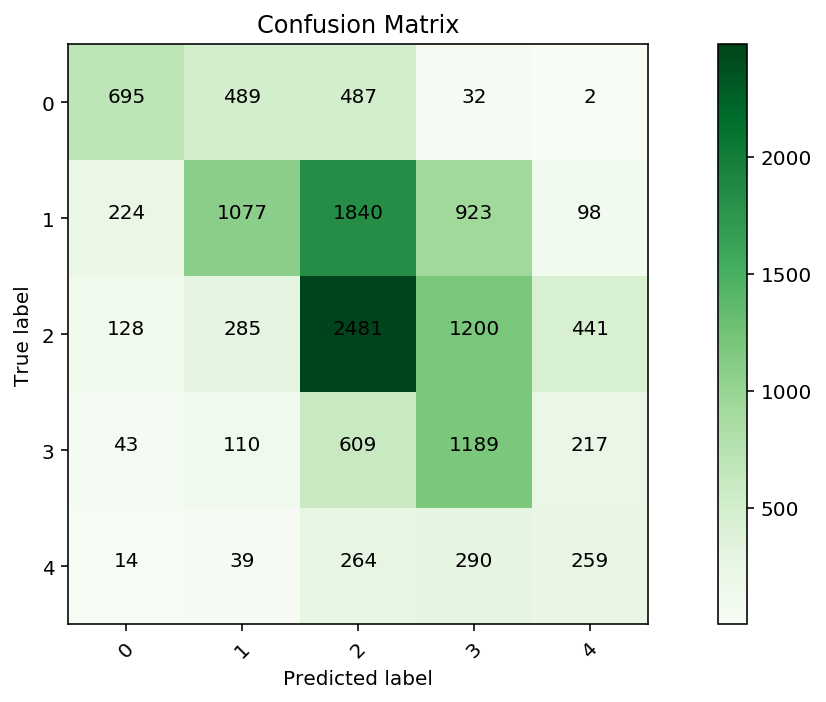

In [36]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= y_results)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Step 6: Use Batch Transform [현재 에러 발생]
이번에는 배치로 추론을 실행해 봅니다. 테스트 데이터셋에 레이블 컬럼을 추가함으로써, 예측 성능을 평가할 수 있습니다. (파라미터로 X_test_s3_path가 아닌 test_s3_path 를 전달하였습니다.)

In [38]:
# output_path = f's3://{bucket}/{prefix}/output/'

# transformer = algo.transformer(instance_count=1, 
#                                instance_type=compatible_inference_instance_type,
#                                strategy='MultiRecord',
#                                max_payload=6,
#                                max_concurrent_transforms=1,                              
#                                output_path=output_path)

# transformer.transform(test_s3_path, content_type='text/csv', split_type='Line')
# transformer.wait()

In [39]:
# !aws s3 ls {output_path}

In [40]:
# !aws s3 cp {output_path}test.csv.out test.csv.out

In [41]:
# !head -n 5 test.csv.out

### Step 7: Clean-up

예측작업이 끝나면 추가 과금을 피하기 위해 엔드포인트를 삭제합니다. 


In [42]:
predictor.delete_endpoint()

In [43]:
#Finally, delete the model you created.
# predictor.delete_model()

마지막으로, 테스트만을 목적으로 AWS 마켓플레이스에 subscribe한 경우 테스트 이후 unsubscribe를 할 수 있습니다.  
subscription을 취소하기 전에 해당 알고리즘이나 모델 패키지로부터 배포된 [모델](https://console.aws.amazon.com/sagemaker/home#/models)에 있지 않은지 확인합니다. - 모델과 연관된 컨테이너를 통해 이를 확인할 수 있습니다.

AWS 마켓플레이스 unsubscribe 하기
1. [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=lbr_tab_ml)의 __Machine Learning__ 탭으로 이동합니다.
1. subscription을 취소하고자 하는 리스트로 이동한 후 __Cancel Subscription__을 클릭합니다.
